### *библиотеки*

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns

### *загрузка данных*

In [2]:
pd.io.parquet.get_engine('auto')

In [3]:
train_df = pd.read_parquet('train.parquet')

In [4]:
train_df.head()

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,48.871217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.064993,33196.020871,1.229488,0.396969,323523.957625,12.420855,9.069157,1,1,1
1,1,19.530576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.270542,33195.488147,1.229488,-0.137339,145641.572203,2.124925,2.069157,0,0,0
2,2,9.706201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.431839,265071.236918,4.229488,3.595162,125727.062161,0.999583,1.069157,0,0,0
3,3,92.569902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.990581,495094.276542,9.229488,8.582252,370392.322955,3.066714,3.069157,0,0,0
4,4,26.538856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393927,33196.317418,1.229488,0.276606,125726.775788,1.219935,1.069157,0,0,0


### *подготовка данных*

In [5]:
columns = list(train_df.columns)

In [6]:
%%time
train_df[columns] = train_df[columns].apply(pd.to_numeric, errors='coerce', axis=1)

CPU times: total: 37.4 s
Wall time: 1min 2s


In [7]:
%%time
train_df = train_df.fillna(train_df.mean())

CPU times: total: 609 ms
Wall time: 1.49 s


### *обучение модели*

In [8]:
cols = ['id', 'total_target', 'target_1', 'target_2']
y = train_df.total_target
X = train_df.drop(cols, axis=1)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [10]:
%%time
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X, y)

CPU times: total: 2min 16s
Wall time: 3min 29s


RandomForestClassifier(max_depth=3, random_state=0)

### *результат обучения*

In [11]:
y_pred = clf.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8576038491940963

### *интерпретация обучения*

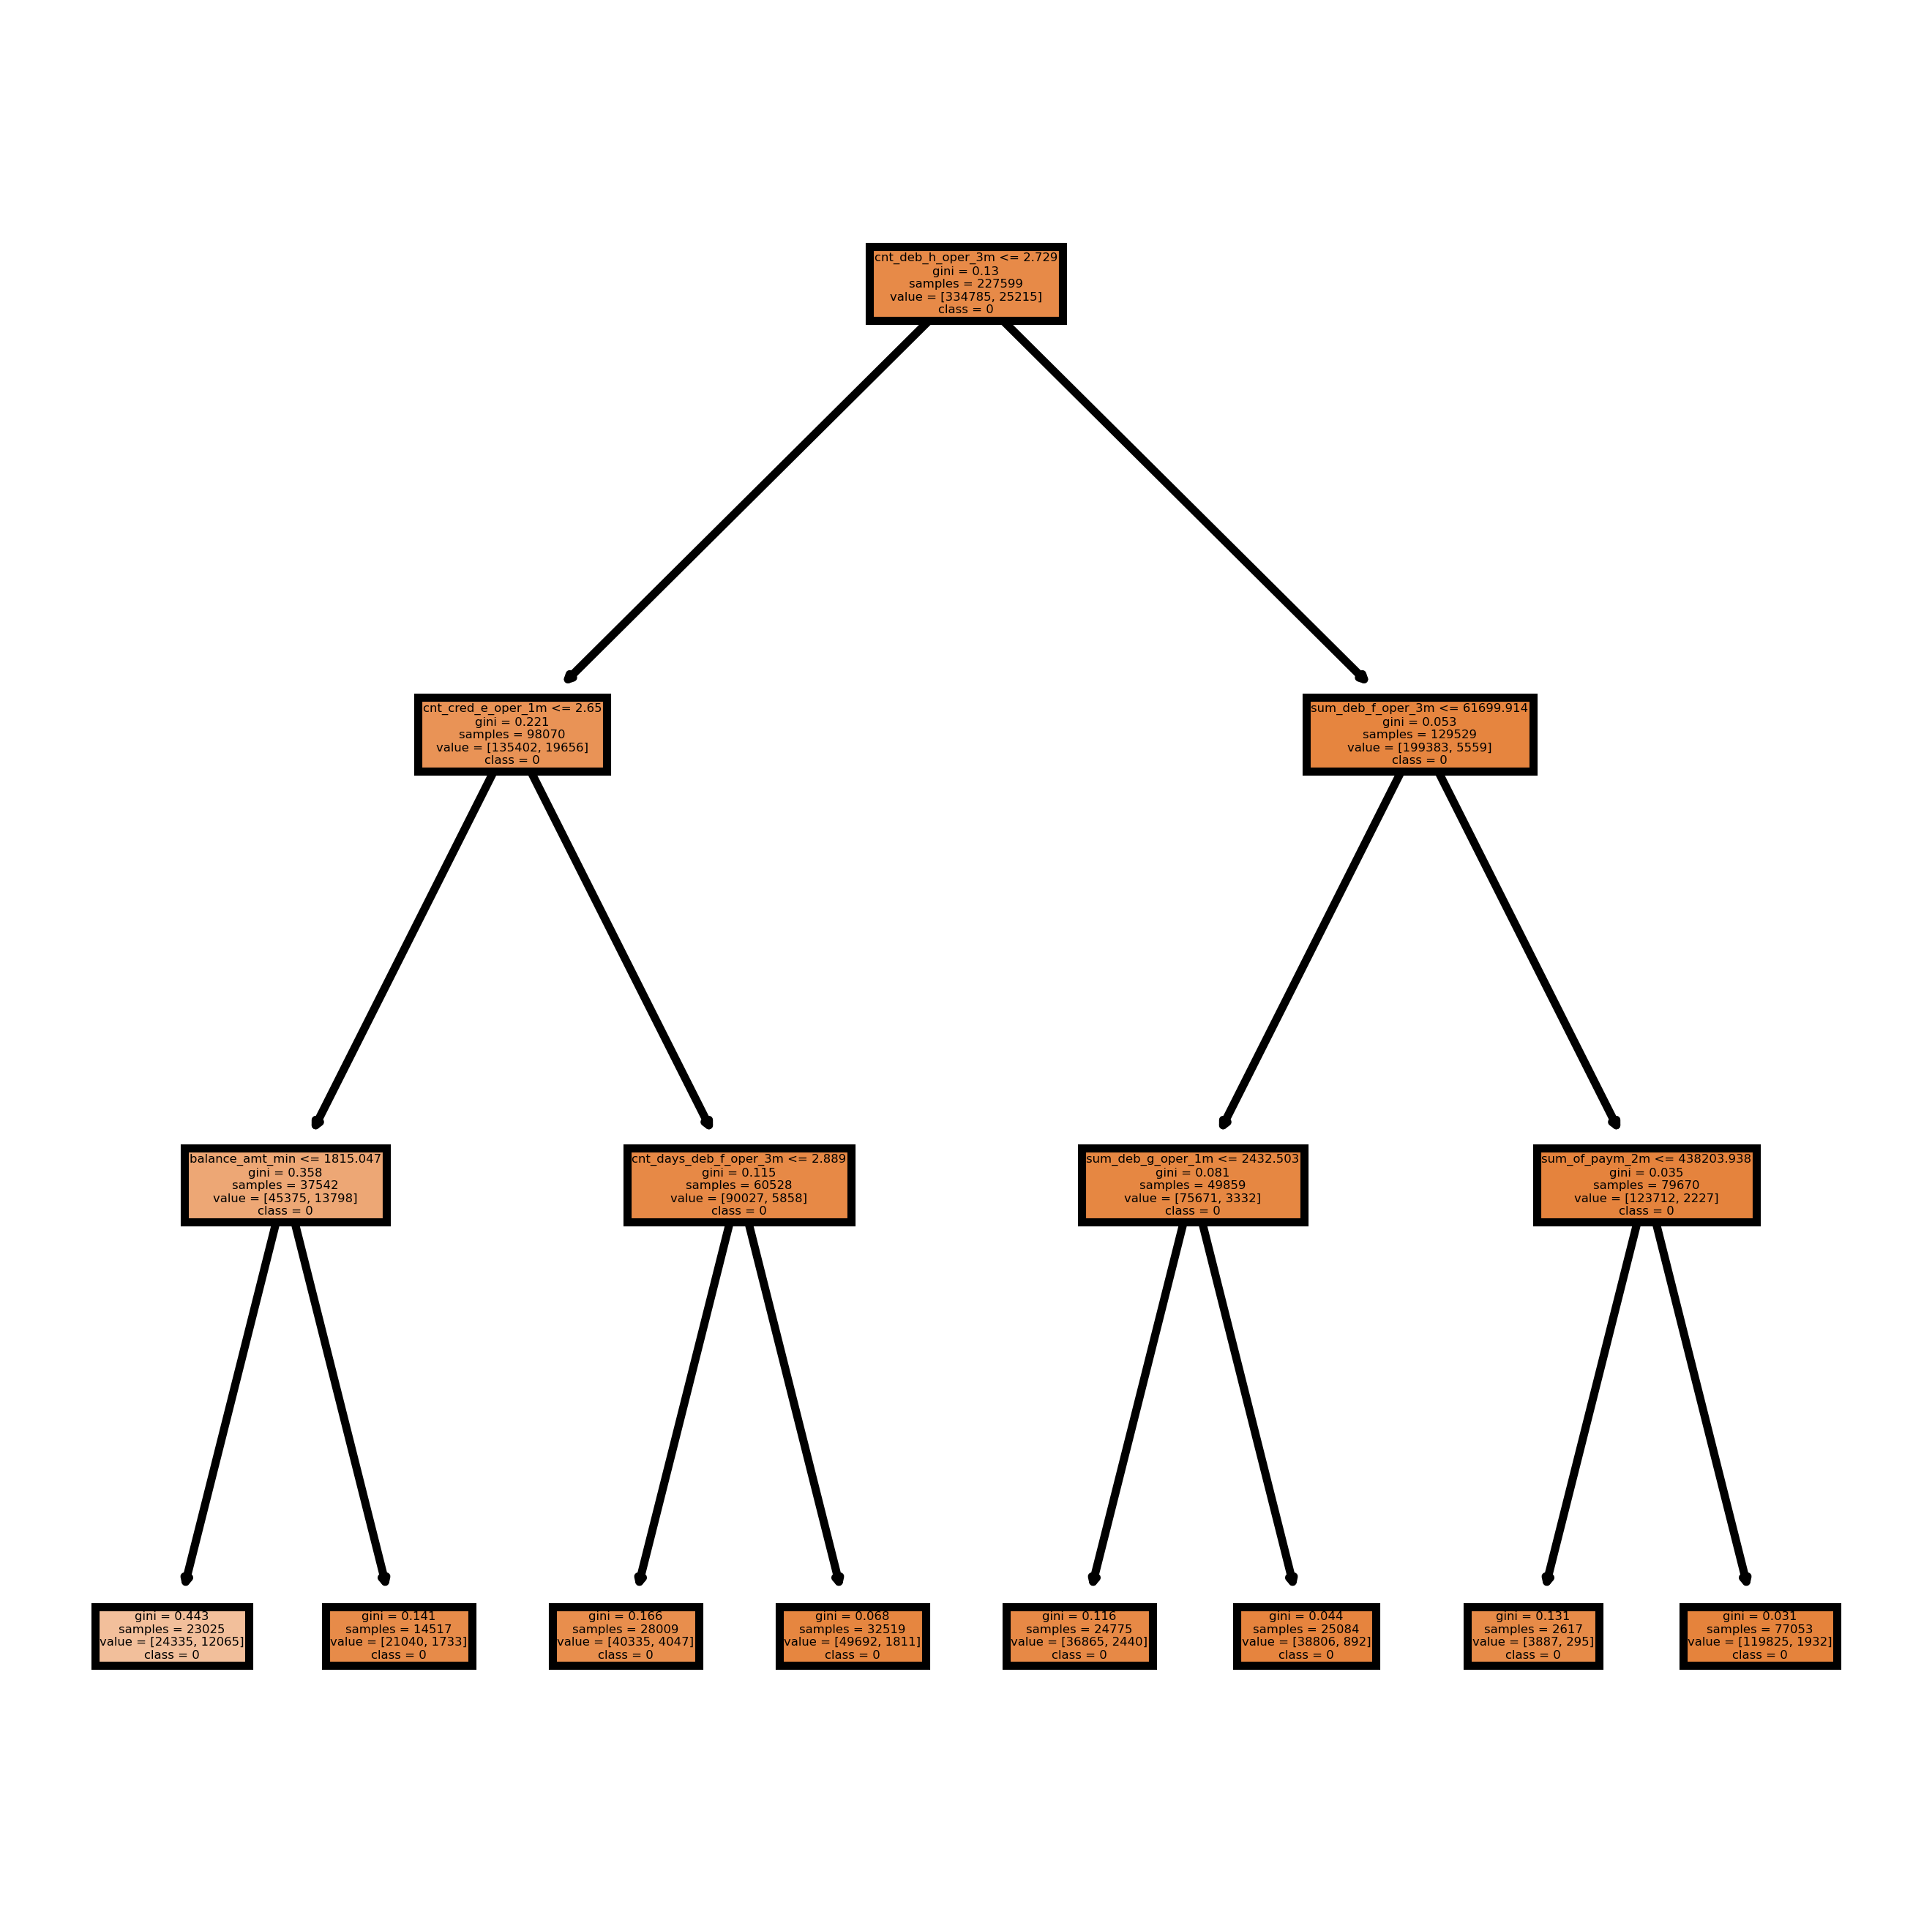

In [12]:
fn=list(x_train.columns)
cn= ['0', '1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

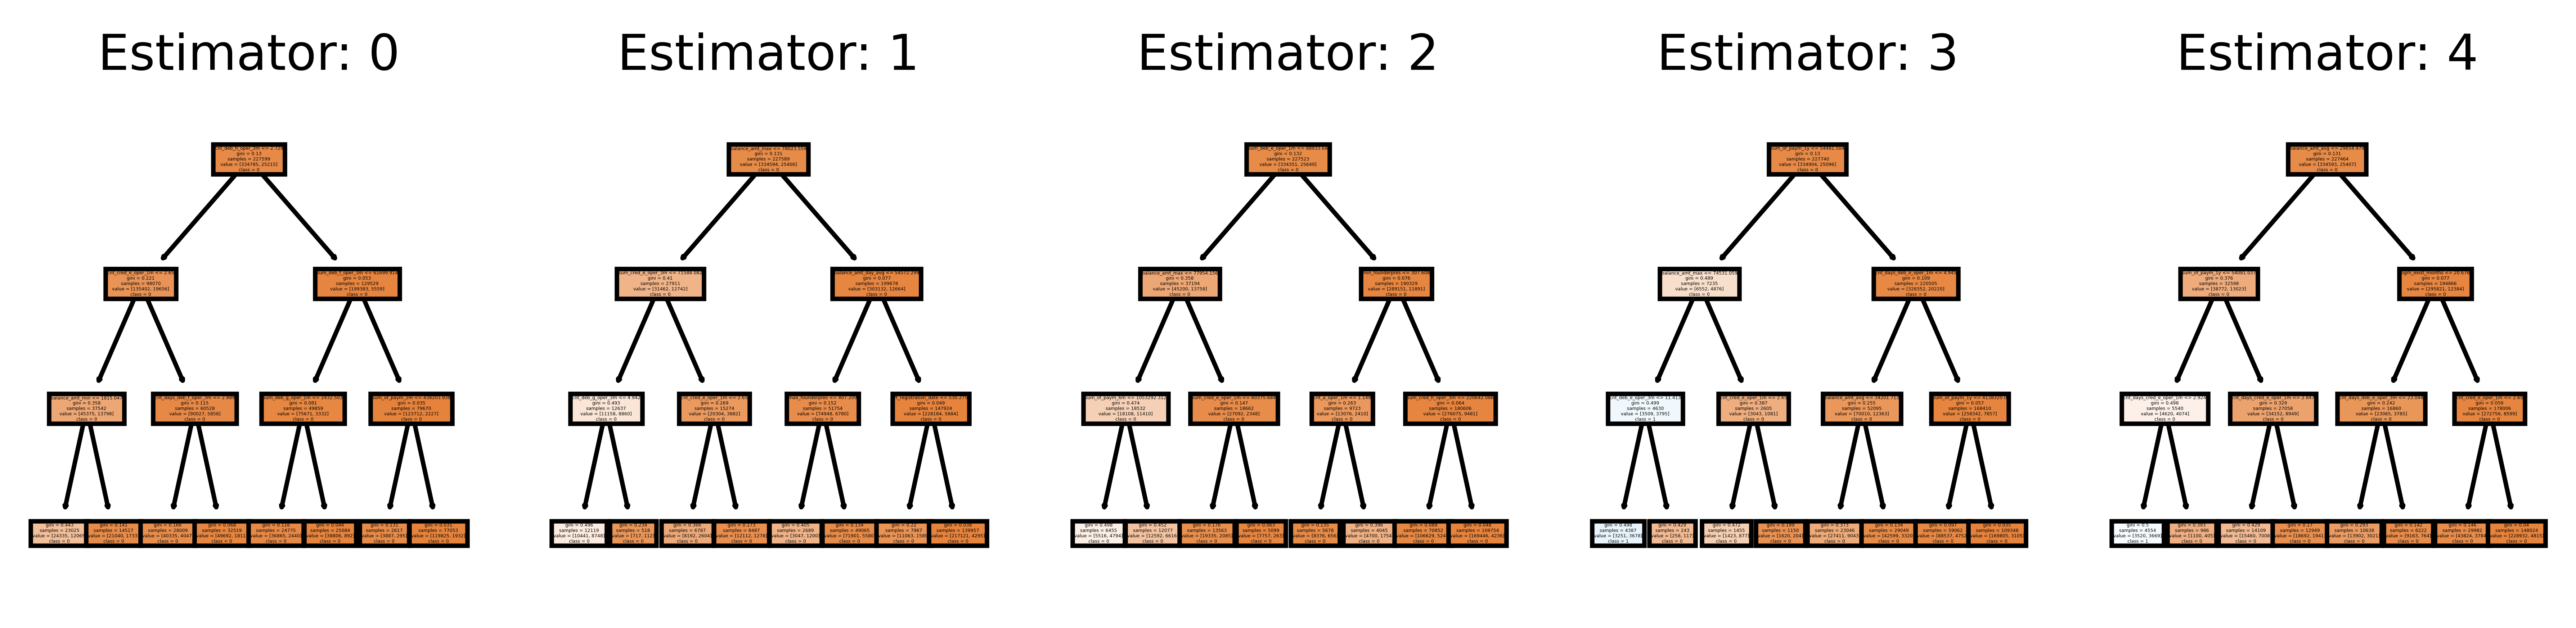

In [13]:
fn=list(x_train.columns)
cn= ['0', '1']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(clf.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

### *важность признаков*

In [14]:
features = clf.feature_importances_
importance = np.column_stack([features, x_train.columns])
sort = sorted(importance, key=lambda x: x[0], reverse=True)
display = sort[:10]
df = pd.DataFrame([[i[1], i[0]] for i in display], columns =['features', 'importance']) 
df

,features,importance
0,balance_amt_max,0.102025
1,balance_amt_day_avg,0.096897
2,balance_amt_avg,0.091469
3,sum_cred_e_oper_3m,0.072505
4,sum_deb_e_oper_3m,0.066601
5,cnt_cred_e_oper_3m,0.057503
6,sum_cred_e_oper_1m,0.050138
7,cnt_days_cred_e_oper_3m,0.049797
8,sum_deb_e_oper_1m,0.049290
9,cnt_days_deb_e_oper_3m,0.044209


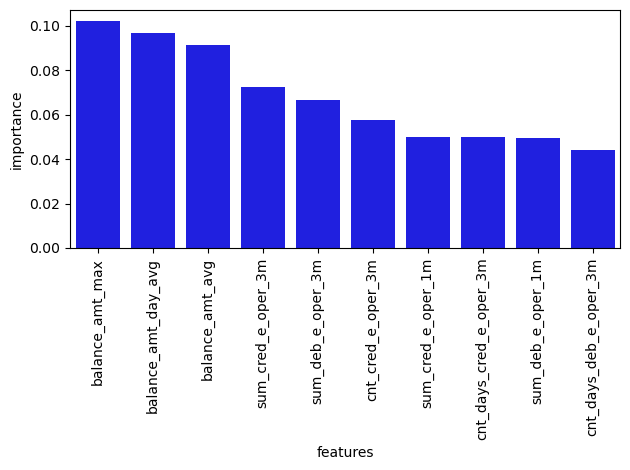

In [15]:
sns.barplot(
    x='features', 
    y='importance', 
    data=df, 
    color='blue')
plt.xticks(rotation=90)
plt.tight_layout()